# *A Bayesian workflow for mitigation analysis and decision making with epidemiological models*

This notebook contains all of the code used to produce the results and figures included in the paper

## Setting: Washington State -- July 31, 2021 (Delta Wave)

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

## Data processing

Hospitalization and ICU data from [Washington State Respiratory Illness Data Dashboard](https://doh.wa.gov/data-and-statistical-reports/diseases-and-chronic-conditions/communicable-disease-surveillance-data/respiratory-illness-data-dashboard#downloads)

*Note that patients in the ICU are also counted as hospitalized.

Death data from [COVID-19 Forecast Hub](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md)

### Process death data

In [48]:
location = "Washington"
data_start_date = '2021-07-10'
data_end_date = '2021-08-01'

### Load data from COVID-19 Forecast Hub GitHub
# # BETTER_NAMES = {'Cases': 'Infected',
# #                 'Hospitalizations': 'Hospitalized',
# #                 'Deaths': 'Dead'}
# # ## instantiate, making sure no dates are skipped between start and end (could be found dynamically)
# # full_dataset = pd.DataFrame({'date':pd.date_range(start='1/22/2020', end='3/29/2024')})

# # ## fill the instantiated dataset
# # for i in ['Cases','Hospitalizations','Deaths']:
# #     all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
# #     subset   = all_data[all_data.location_name == location].groupby("date")["value"].sum().reset_index()
# #     subset.date = pd.to_datetime(subset.date)
# #     subset['cumsum'] = subset.value.cumsum()
# #     full_dataset = full_dataset.merge(subset[['date','cumsum']], how='outer', on='date').rename(columns={'cumsum':BETTER_NAMES[i]})

# # full_dataset[(full_dataset.date >= '2021-06-01') & (full_dataset.date < '2021-09-06')].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

# # # Save full dataset
# # full_dataset.to_csv('full_dataset.csv', index=False)

# Read full dataset
full_dataset = pd.read_csv('full_dataset.csv')

## Define a function to select a subset of the data
def get_data_between(start=data_start_date,end=data_end_date):
    return full_dataset[(full_dataset.date >= start) & (full_dataset.date < end)].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

data_df = get_data_between()
data_df.set_index("Timestamp", inplace=True)
print(data_df)
data_df.to_csv('wa_covid_data.csv')

           Infected  Hospitalized    Dead
Timestamp                                
0          455103.0       19802.0  5997.0
1          455103.0       19832.0  5997.0
2          456709.0       19875.0  6000.0
3          457814.0       19919.0  6022.0
4          458517.0       19964.0  6027.0
5          459306.0       20012.0  6036.0
6          460067.0       20052.0  6042.0
7          460067.0       20097.0  6042.0
8          460067.0       20144.0  6042.0
9          461847.0       20186.0  6043.0
10         462577.0       20246.0  6056.0
11         463537.0       20305.0  6063.0
12         466099.0       20364.0  6066.0
13         466099.0       20411.0  6066.0
14         466235.0       20473.0  6078.0
15         466235.0       20538.0  6078.0
16         469308.0       20610.0  6089.0
17         470333.0       20699.0  6097.0
18         471489.0       20775.0  6100.0
19         472362.0       20861.0  6119.0
20         473076.0       20938.0  6122.0
21         473076.0       21004.0 

### Plot the data

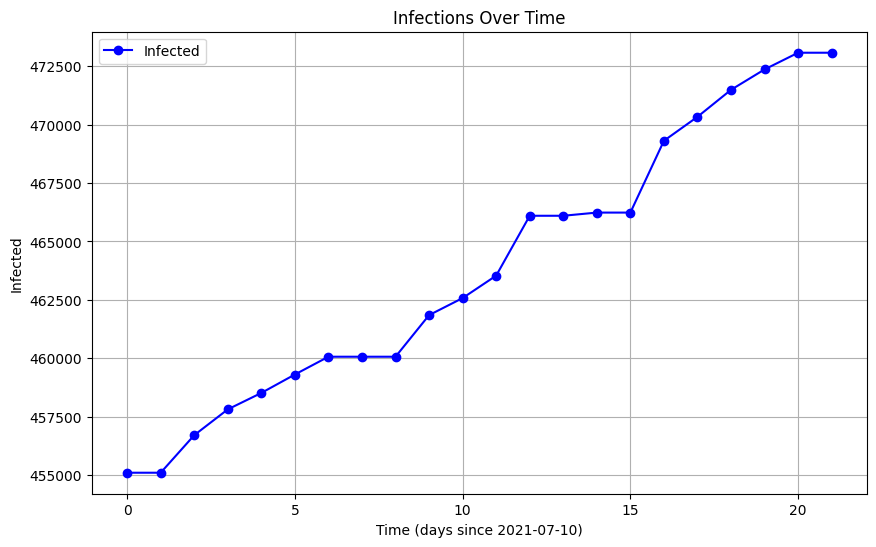

In [49]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_df.index, data_df['Infected'], marker='o', linestyle='-', color='b', label='Infected')

plt.xlabel('Time (days since ' + data_start_date + ')')
plt.ylabel('Infected')
plt.title('Infections Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Gather population values and initial conditions

Population values from [Census Reporter - Washington State](https://censusreporter.org/profiles/04000US53-washington/)

Initial conditions estimated from [COVID-19 Forecast Hub (CFH)](https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md) and [Washington State Department of Health Respiratory Illness Data Dashboard](https://doh.wa.gov/data-and-statistical-reports/diseases-and-chronic-conditions/communicable-disease-surveillance-data/respiratory-illness-data-dashboard#Vaccination)

In [50]:
WA_state_total_pop = 7_785_786 # US Census Bureau
initial_vacc = 8_228_240 / 5 # Fully vaccinated June 2021, from WA State Dept. of Health
vacc_per_day = 10_000 / 2 # from NYT data
vacc_efficacy = 0.87 # Vaccination efficacy against transmission for Delta variant, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10073587/
initial_deaths = 5997.0 # from CFH data
initial_hosp = 504.0 # from NYT
initial_recovered = 452072.0 # Estimate of recovered population = cumulative cases 10 days prior, from CFH data 
initial_cases = 4000.0 # Estimate of active cases, from CFH data
initial_exposed = 4*initial_cases # Estimate of exposed population
initial_ccases = 455103.0 # from CFH data
initial_chosp = 19802.0 # from CFH data
initial_susceptible = WA_state_total_pop - (initial_deaths + initial_hosp + initial_recovered + initial_vacc + initial_cases + initial_exposed)

# Model derivation and initialization

### Define units

In [51]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [52]:
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}), # Susceptible
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '00000154'}), # Exposed
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}), # Infectious
    'R': Concept(name='R', units=person_units(), identifiers={'ido': '0000592'}), # Recovered
    
    'H': Concept(name="H", units=person_units(), identifiers={"ido": "0000511"},
                        context={"property": "ncit:C25179"}), # Hospitalized
    'V': Concept(name="V", units=person_units()), # Vaccinated
    'D': Concept(name="D", units=person_units(), identifiers={"ncit": "C28554"}), # Deceased
    'C_c': Concept(name="C_c", units=person_units()), # Cumulative Cases
    'C_h': Concept(name="C_h", units=person_units()), # Cumulative Hospitalizations
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [66]:
parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.12), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.11,
                                                            'maximum': 0.13})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(WA_state_total_pop), units=person_units()),  # Total population
    'vacc_mult': Parameter(name='vacc_mult', value=sympy.Float(1 - vacc_efficacy), units=person_units()),  # Transmission for vaccinated

    'NPI_mult': Parameter(name='NPI_mult', value=sympy.Float(1.0), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.999,
                                                            'maximum': 1.001})),  # NPI multiplier (masking)
    
    'r_EI': Parameter(name='r_EI', value=sympy.Float(0.167), units=per_day_units(),
                     distribution=None),  # Rate of progressing E -> I, (Latency period)^-1
    
    'r_IR': Parameter(name='r_IR', value=sympy.Float(0.143), units=per_day_units(),
                 distribution=None),  # Rate of progressing I -> H or R, (Infectious period)^-1

    'p_IH': Parameter(name='p_IH', value=sympy.Float(0.095), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.09,
                                                            'maximum': 0.1})),  # Percent of I -> H
    
    'r_HR': Parameter(name='r_HR', value=sympy.Float(0.222), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.2,
                                                            'maximum': 0.25})),  # Rate of progressing H -> R 
    
    'p_HD': Parameter(name='p_HD', value=sympy.Float(0.085), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.08,
                                                            'maximum': 0.09})),  # Percent H -> D

    'r_RS': Parameter(name='r_RS', value=sympy.Float(0.0027), units=per_day_units(),
                 distribution=None),  # Rate of progressing R -> S
    
    'r_V': Parameter(name='r_V', value=sympy.Float(vacc_per_day), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': vacc_per_day*0.99,
                                                            'maximum': vacc_per_day*1.01})),  # Rate of progressing S, R -> V

}

### Define `SymPy` variables

In [67]:
S, E, I, R, H, V, D, C_c, C_h, beta, N, vacc_mult, NPI_mult, r_EI, r_IR, p_IH, r_HR, p_HD, r_RS, r_V = sympy.symbols(
    'S E I R H V D C_c C_h beta N vacc_mult NPI_mult r_EI r_IR p_IH r_HR p_HD r_RS r_V ')

### Set initial conditions

In [68]:
initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_cases),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    'C_c': Initial(concept=c["C_c"], expression=initial_ccases),
    'C_h': Initial(concept=c["C_h"], expression=initial_chosp),
}

### Define templates

In [69]:
##### S -> E
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*NPI_mult*S*I / N
)


##### V -> E
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*NPI_mult*vacc_mult*V*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=r_EI*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=r_IR*(1 - p_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=r_IR*p_IH*I
)


#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=r_HR*(1 - p_HD)*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=r_HR*p_HD*H
)


#### R -> S
rs = NaturalConversion(
    subject=c['R'],
    outcome=c['S'],
    rate_law=r_RS*R
)


### Vaccination
# R -> V
rv = NaturalConversion(
    subject=c['R'],
    outcome=c['V'],
    rate_law=r_V
)

# S -> V
sv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=r_V
)


### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=r_EI*E
)

# Cumulative Hospitalizations
chosp = ControlledProduction(
    controller=c['I'],
    outcome=c['C_h'],
    rate_law=r_IR*p_IH*I
)

### Define observables

In [70]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c),
    'c_hosp': Observable(name='c_hosp', expression=C_h),
}

### Define template model and save as petrinet AMR

In [71]:
seir_model = TemplateModel(
    templates=[
        se,
        ve,
        ei,
        ir,
        ih,
        hr,
        hd,
        rs,
        rv,
        sv,
        ccases,
        chosp,
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEIRHUVD model')
)

# Save as JSON
with open("WA_delta_base_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

In [72]:
model1 = "WA_delta_base_model.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 150.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]
data_mapping = {'Infected': 'c_cases', 'Hospitalized': 'c_hosp', 'Dead': 'deceased'}

dataset = "wa_covid_data.csv"

### Sample from model prior and plot output

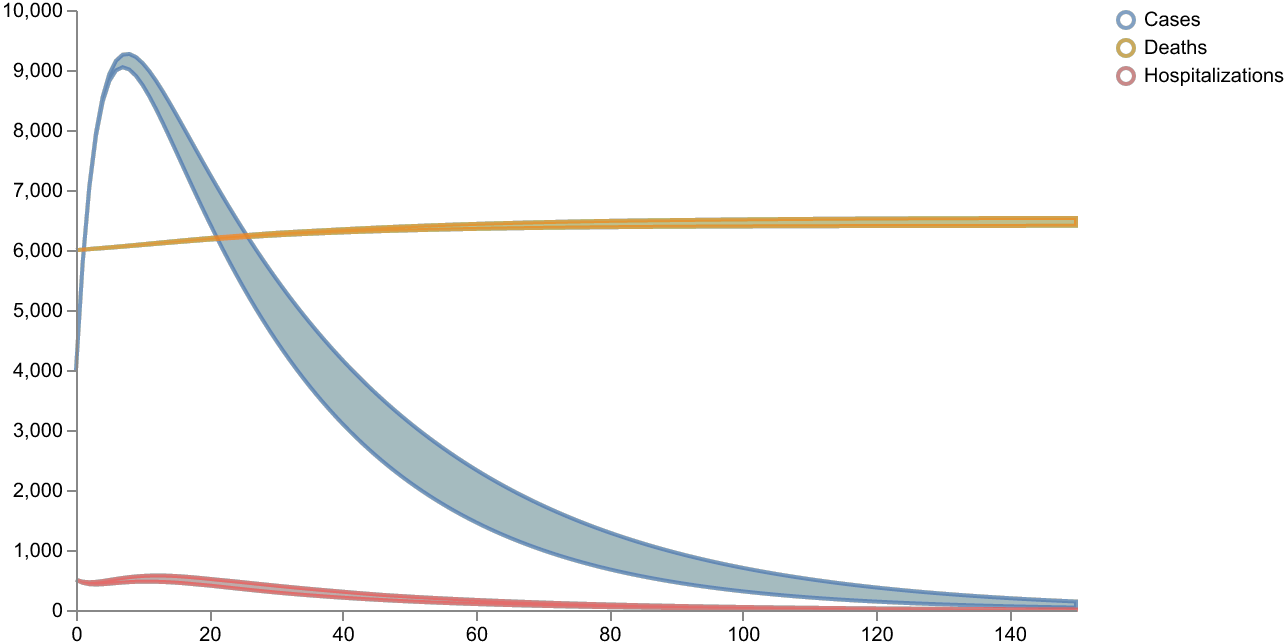

In [73]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
        }

schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Calibrate model to data

In [74]:
end_time = 50.0
calibrated_results1 = pyciemss.calibrate(model1, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates1 = calibrated_results1["inferred_parameters"]

display(parameter_estimates1())

calibrated_sample_results1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates1)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 21 rows of data. The first column, Timestamp, begins at 0 and ends at 21. The subsequent columns are named: Infected, Hospitalized, Dead


{'persistent_NPI_mult': tensor(0.9997, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1216, grad_fn=<ExpandBackward0>),
 'persistent_p_IH': tensor(0.0982, grad_fn=<ExpandBackward0>),
 'persistent_p_HD': tensor(0.0823, grad_fn=<ExpandBackward0>),
 'persistent_r_HR': tensor(0.2151, grad_fn=<ExpandBackward0>),
 'persistent_r_V': tensor(4970.6938, grad_fn=<ExpandBackward0>)}

### Plot the result

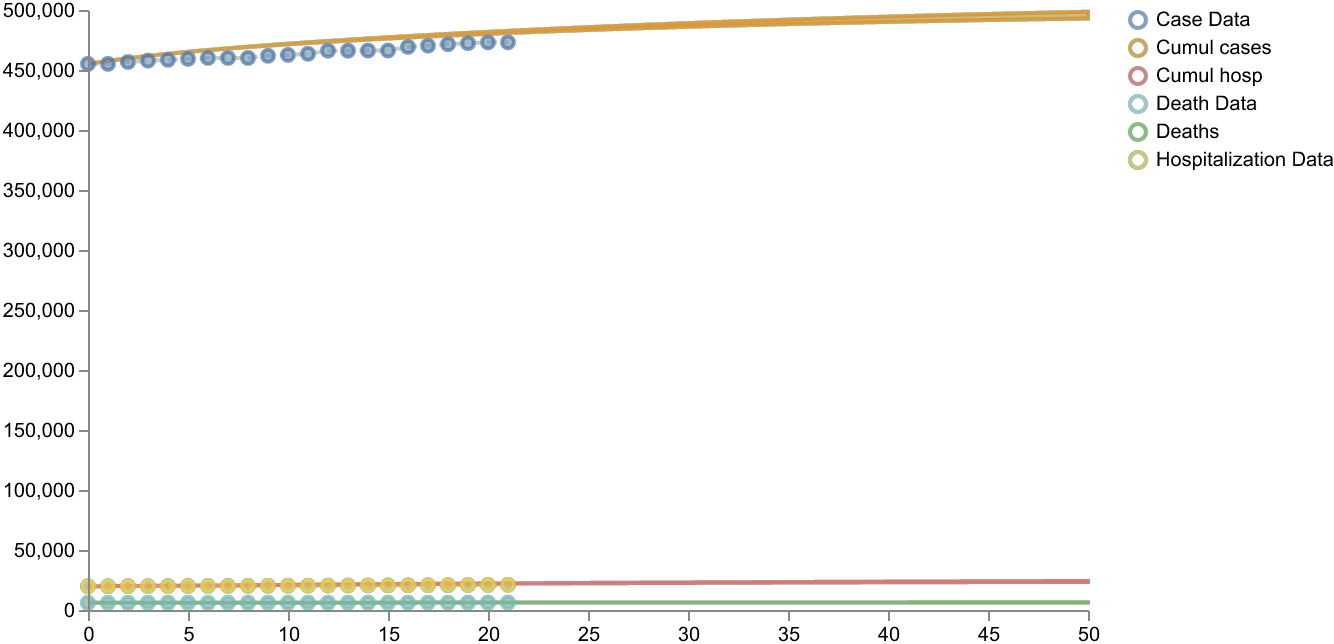

In [75]:
nice_labels_cumul = {
        "c_cases_observable_state": "Cumul cases",
        "c_hosp_observable_state": "Cumul hosp", 
        "deceased_observable_state": "Deaths"
        }
nice_data_names = {
        "Infected": "Case Data",
        "Hospitalized": "Hospitalization Data",
        "Dead": "Death Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results1["data"]), 
    keep=["c_cases_observable_state", "c_hosp_observable_state", "deceased_observable_state"], 
    relabel=nice_labels_cumul,
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

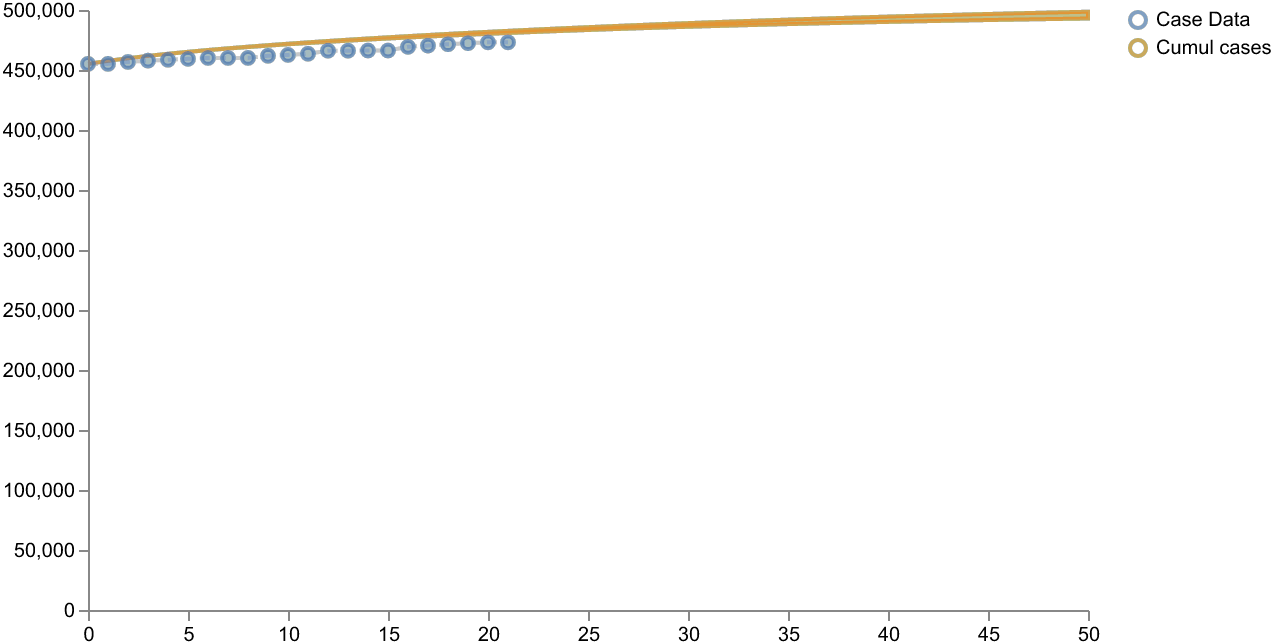

In [76]:
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results1["data"]), 
    keep="c_cases_observable_state", 
    relabel=nice_labels_cumul,
    points=data_df.drop(columns=['Timestamp', "Hospitalization Data", "Death Data"]).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

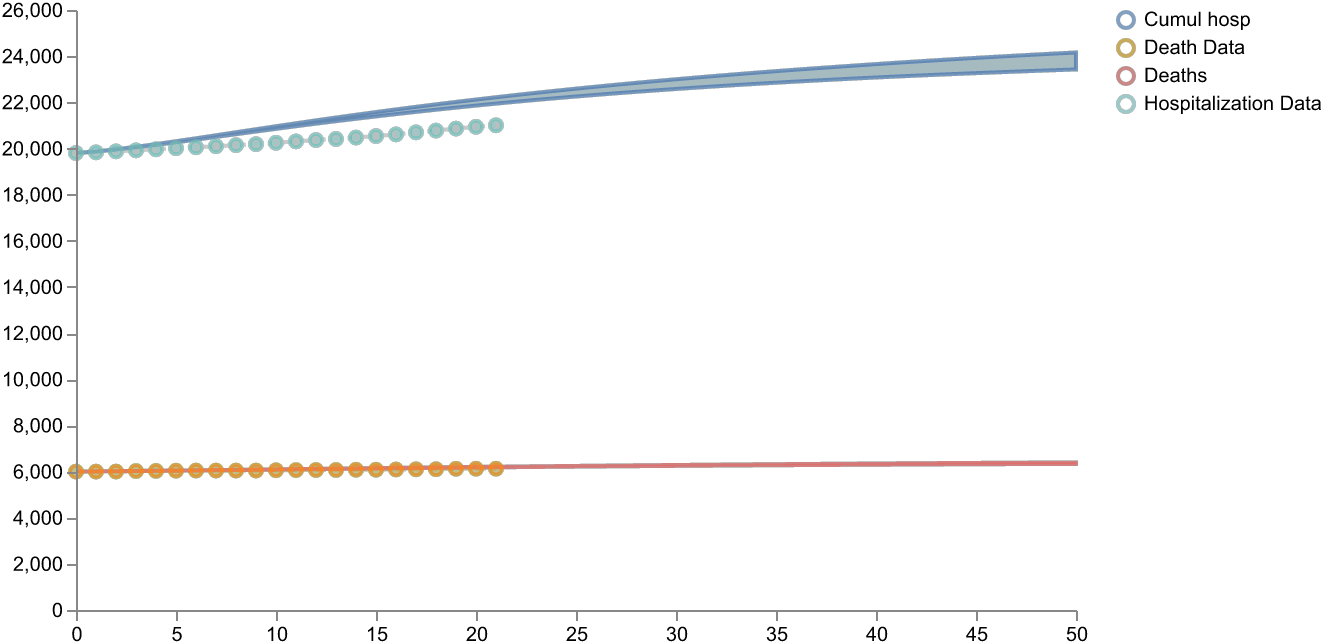

In [77]:
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results1["data"]), 
    keep=["c_hosp_observable_state", "deceased_observable_state"], 
    relabel=nice_labels_cumul,
    points=data_df.drop(columns=['Timestamp', "Case Data"]).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

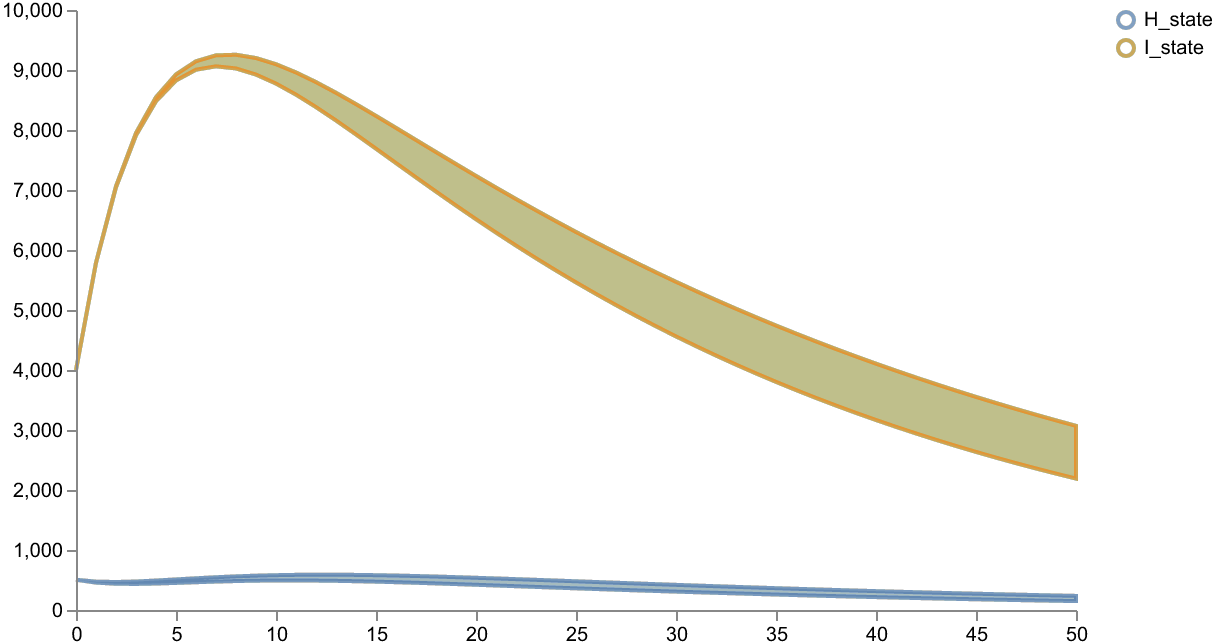

In [78]:
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results1["data"]), 
    keep=["I_state", "H_state"], 
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Calibrate model to data with interventions

In [27]:
mult1 = 2.4
t_variant = 29.0
calibrated_results = pyciemss.calibrate(model1, dataset, data_mapping=data_mapping, num_iterations=num_iterations,
                                       static_parameter_interventions = {torch.tensor(t_variant): {"beta": lambda x : x*mult1, 
                                                                                              "p_IH": lambda x : x*mult1,
                                                                                              "p_IU": lambda x : x*mult1}})
parameter_estimates = calibrated_results["inferred_parameters"]

display(parameter_estimates())

calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates,
                                           static_parameter_interventions = {torch.tensor(t_variant): {"beta": lambda x : x*mult1, 
                                                                                                  "p_IH": lambda x : x*mult1,
                                                                                                  "p_IU": lambda x : x*mult1
                                                                                                 }})
# display(calibrated_sample_results["data"].head())

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 61 rows of data. The first column, Timestamp, begins at 0 and ends at 61. The subsequent columns are named: hosp, icu, dead


{'persistent_NPI_mult': tensor(0.9995, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1681, grad_fn=<ExpandBackward0>),
 'persistent_p_IH': tensor(0.1308, grad_fn=<ExpandBackward0>),
 'persistent_p_IU': tensor(0.0232, grad_fn=<ExpandBackward0>),
 'persistent_p_HD': tensor(0.0820, grad_fn=<ExpandBackward0>),
 'persistent_p_UD': tensor(0.1475, grad_fn=<ExpandBackward0>),
 'persistent_r_V': tensor(4980.9570, grad_fn=<ExpandBackward0>)}

# Plot deaths

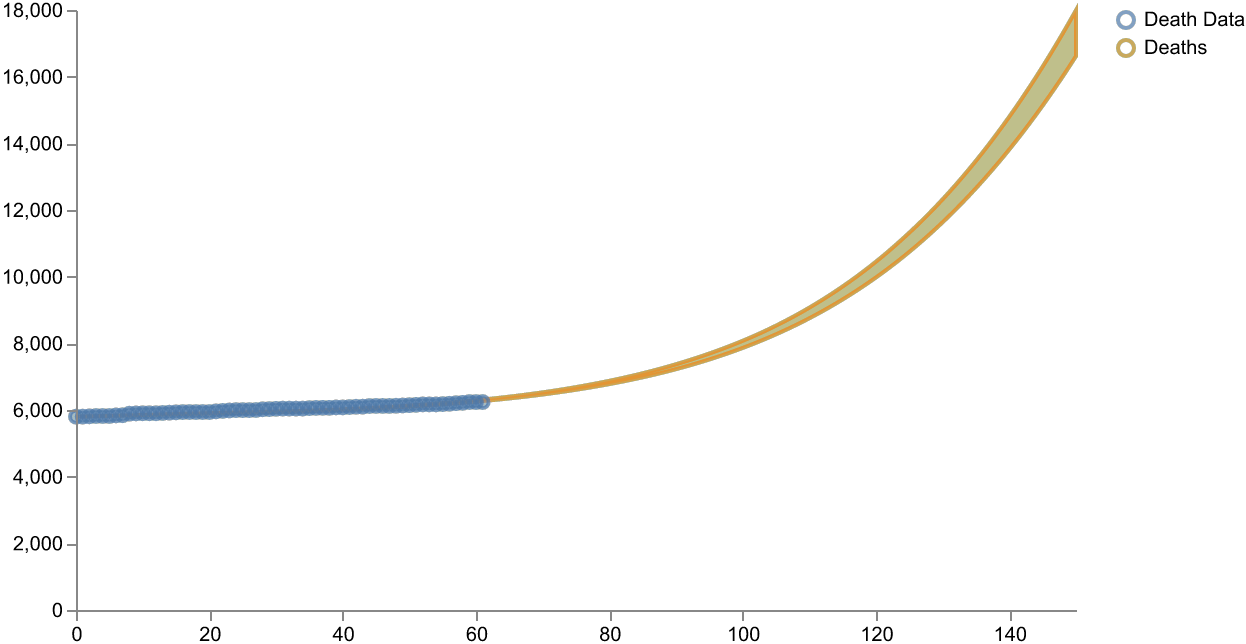

In [28]:
# Plot the result
nice_labels = {
        "deceased_observable_state": "Deaths", 
        }
nice_data_names = {
        "dead": "Death Data"
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', "hosp", "icu"]).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot hospitalizations

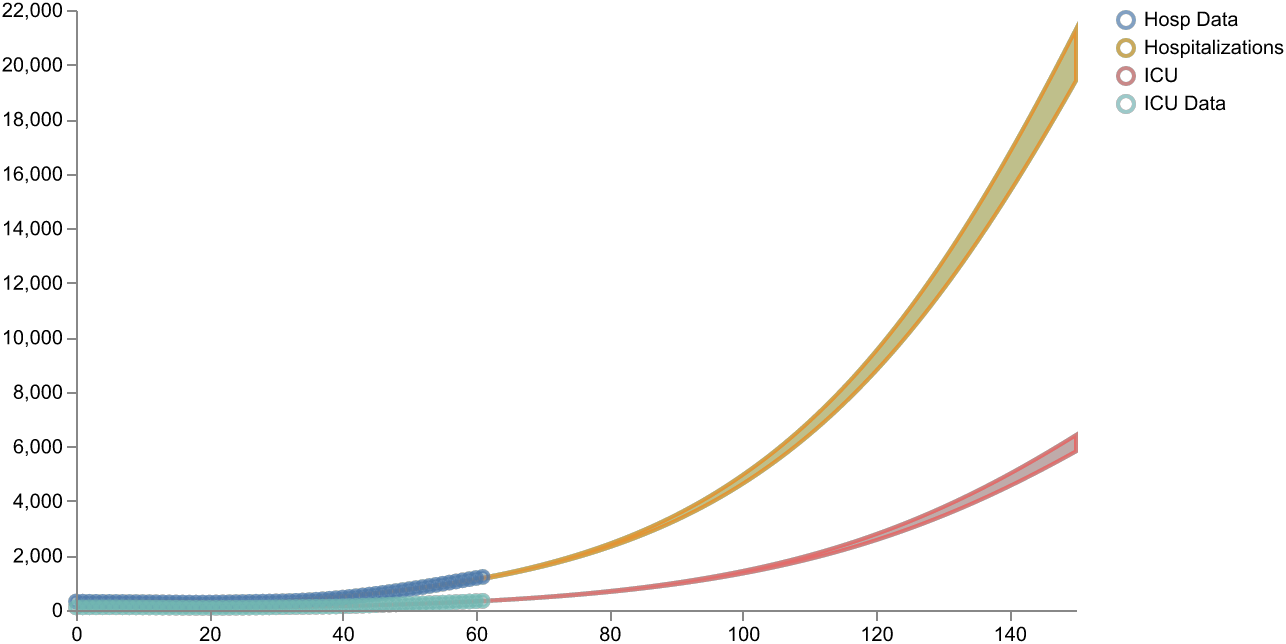

In [29]:
# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        }
nice_data_names = {
        "hosp": "Hosp Data",
        "icu": "ICU Data",
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["hospitalized_observable_state", "icu_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'dead']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Find the number of vaccinations per day to keep ICU hospitalizations below X and total hospitalizations below Y

### Set up optimization and define QoI

In [30]:
num_samples_ouu = 100 # controls accuracy of risk estimation in each optimization iteration
maxiter = 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 30  # maximum number of function evaluations in each instance of local convex optimization

# Define QOI as maximum value over entire simulation
def obs_max_qoi(samples: Dict[str, torch.Tensor], contexts: List) -> np.ndarray:
    """
    Return maximum value over simulated time.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.max(dataQoI, axis=1)

### Perform optimization for number of vaccinations per day

In [31]:
end_time = 150.0

# Define optimization problem setup
observed_params = ["H_state"]
intervention_time = [torch.tensor(62.0)]
intervened_params = ["r_V"]
current_param_value = vacc_per_day
initial_guess_interventions = 20000
bounds_interventions = [[vacc_per_day - 10], [90000]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 6000.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: np.abs(current_param_value - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    fixed_static_parameter_interventions = {torch.tensor(30.0): {"beta": lambda x : x*mult1, 
                                            "p_IH": lambda x : x*mult1,
                                            "p_IU": lambda x : x*mult1
                                           }},
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

 86%|███████████████████████████████████████▍      | 103/120 [03:55<00:38,  2.29s/it]

Optimal policy: tensor([20237.9346], dtype=torch.float64)
{'policy': tensor([20237.9346], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 15237.934574177456
                          x: [ 2.024e+04]
                        nit: 3
      minimization_failures: 3
                       nfev: 103
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 15237.934574177456
                                   x: [ 2.024e+04]
                                nfev: 20
                               maxcv: 0.0}


In [32]:
policy1 = static_parameter_interventions(opt_result1["policy"])
display(policy1)
intervention_time = next(iter(policy1))

{62.0: {'r_V': tensor(20237.9355)}}

### Sample with the intervention implemented at the optimal time and plot the results

In [33]:
optimized_result = pyciemss.sample(
    model1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions={torch.tensor(30.0): {"beta": lambda x : x*mult1,
                                                          "p_IH": lambda x : x*mult1,
                                                          "p_IU": lambda x : x*mult1
                                                          },
                                    torch.tensor(intervention_time): policy1[intervention_time]}
)

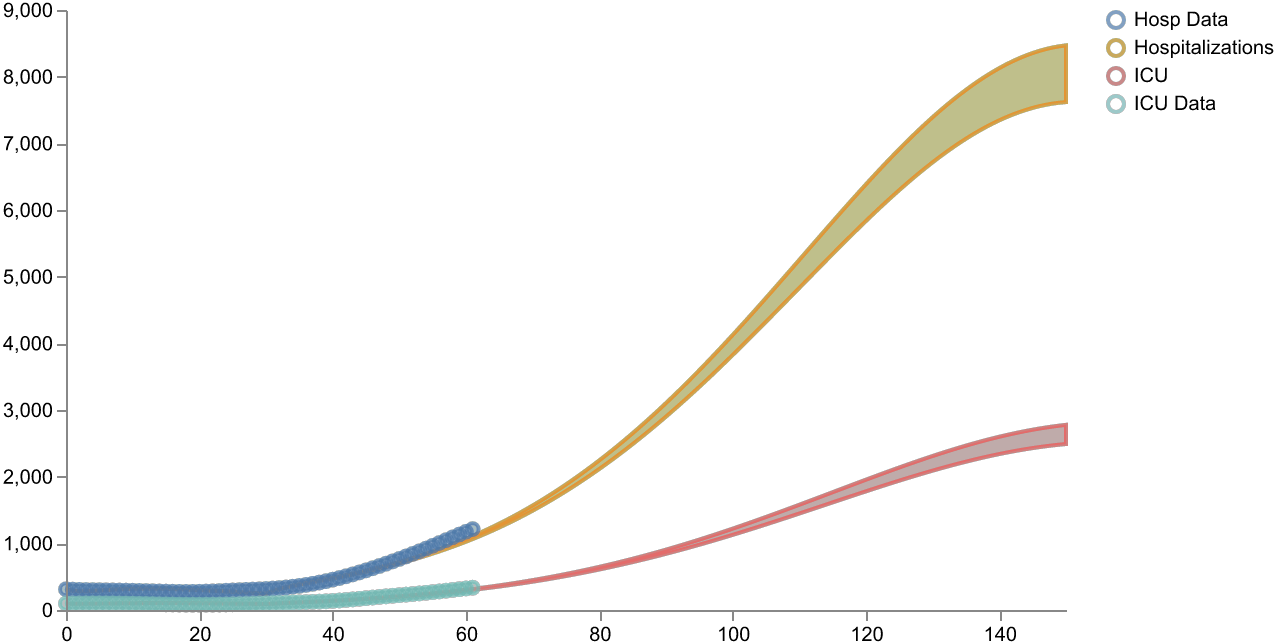

In [34]:
# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        }
nice_data_names = {
        "hosp": "Hosp Data",
        "icu": "ICU Data",
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(optimized_result["data"]), 
    keep=["hospitalized_observable_state", "icu_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'dead']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

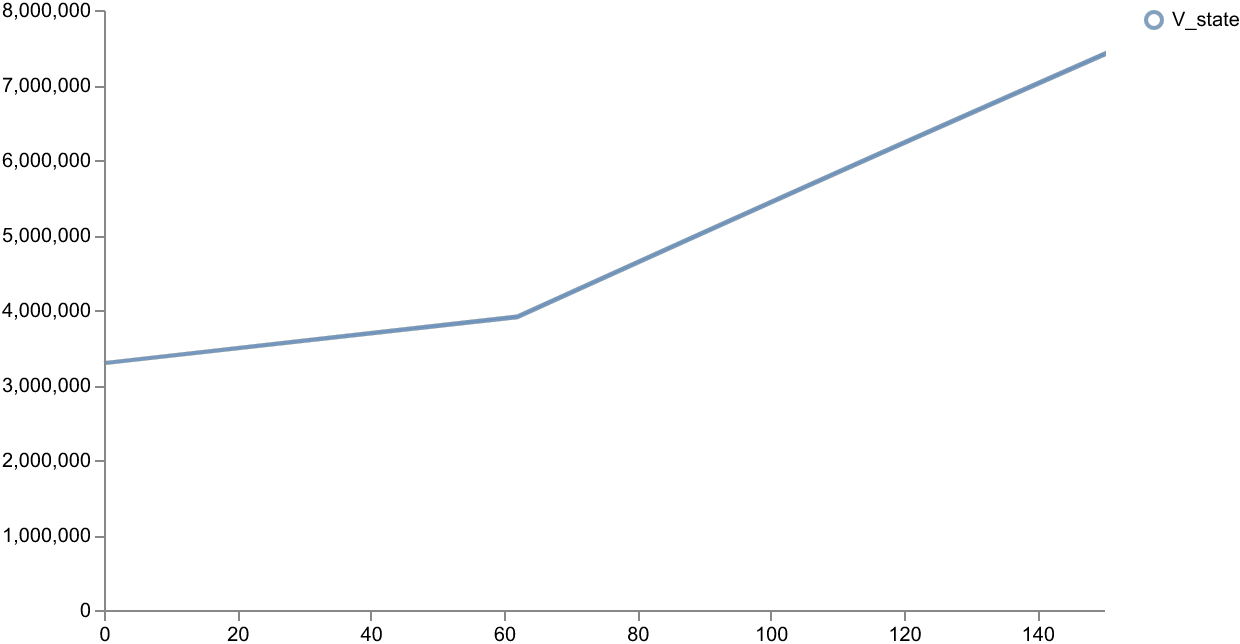

In [35]:
# Plot the result
nice_labels = {
        "V_state": "Vaccinated", 
        }

schema = plots.trajectories(
    pd.DataFrame(optimized_result["data"]), 
    keep=["V_state"], 
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Mask mandate

In [36]:
end_time = 150.0

# Define optimization problem setup
observed_params = ["U_state"] #["H_state"]
intervened_params = ["NPI_mult"]
initial_guess_interventions = 68.0
bounds_interventions = [[62.0], [149.0]]    # bounds should be within start_time and end_time
intervention_value = torch.tensor([0.75])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 3000.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: x #np.abs(initial_guess_interventions - x)

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    fixed_static_parameter_interventions = {torch.tensor(30.0): {"beta": lambda x : x*mult1, 
                                            "p_IH": lambda x : x*mult1,
                                            "p_IU": lambda x : x*mult1
                                           }},
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)

  2%|█▏                                              | 3/120 [00:08<04:58,  2.55s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  4%|██                                              | 5/120 [00:10<03:15,  1.70s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  6%|██▊                                             | 7/120 [00:12<02:38,  1.41s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  8%|███▌                                            | 9/120 [00:14<02:20,  1.26s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penal

Optimal policy: tensor([62.0001], dtype=torch.float64)
{'policy': tensor([62.0001], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 62.00001
                          x: [ 6.200e+01]
                        nit: 3
      minimization_failures: 0
                       nfev: 93
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 62.00001
                                   x: [ 6.200e+01]
                                nfev: 23
                               maxcv: 0.0}


In [37]:
policy2 = static_parameter_interventions(opt_result2["policy"])
display(policy2)
intervention_time = next(iter(policy2))

{62.0001: {'NPI_mult': tensor(0.7500)}}

In [38]:
optimized_result = pyciemss.sample(
    model1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions={torch.tensor(30.0): {"beta": lambda x : x*mult1,
                                                          "p_IH": lambda x : x*mult1,
                                                          "p_IU": lambda x : x*mult1
                                                          },
                                    torch.tensor(intervention_time): policy2[intervention_time]}
)

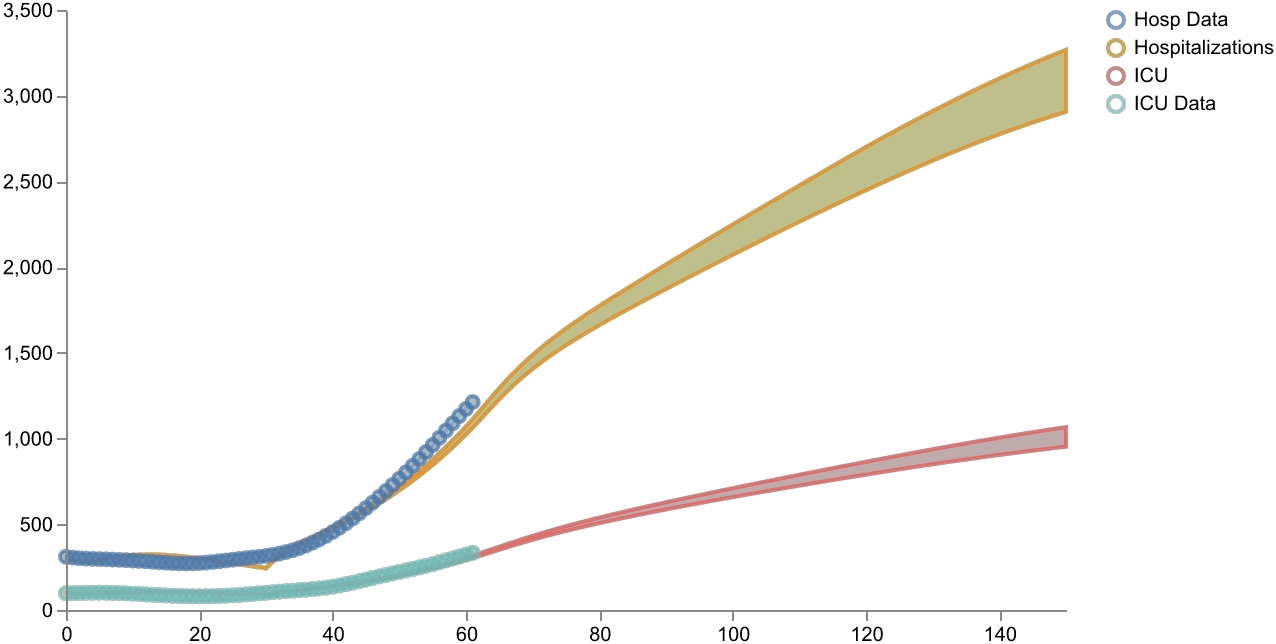

In [39]:
# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        "icu_observable_state": "ICU",
        }
nice_data_names = {
        "hosp": "Hosp Data",
        "icu": "ICU Data",
        }
data_df = pd.read_csv(dataset)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(optimized_result["data"]), 
    keep=["hospitalized_observable_state", "icu_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'dead']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)